# Liscense Plate Detection with WPOD-NET

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from utils import detect_lp
from os.path import splitext,basename
from utils import detect_lp

import tensorflow as tf
import keras
from keras.models import model_from_json
import glob

Using TensorFlow backend.


In [2]:
def load_model(model_path, model_weights):
    '''
    Input (STR): path to model.json, model.h5
    reads the model path, get model architecture from .json then load
    the weights from .h5 
    '''
    try:
        # parse json string to initialize model instance       
        with open(model_path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects=None)
        # load model weights
        model.load_weights(model_weights)
        print('Loaded model successfully...')
        
        return model
    except Exception as e:
        print(e)
        
        

In [3]:
wpod_net = load_model('wpod-net.json', 'wpod-net.h5')
# wpod_net.summary()

Loaded model successfully...


## Pre-process inputs

In [4]:
def preprocess(img_path, resize=False):
    '''
    Input: (STR) image path, (Bool) resize
    Output: processed version of image
    '''
    im = cv2.imread(img_path)
    # convert to RGB
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # standardize pixels between 0 and 1     
    im = im / 255
    # resize: if dim not (224,224)    
    if resize:
        im = cv2.resize(im, (224,224))
    return im

## Code to license plate detection

## Should a batch of input images

Found 526 images...


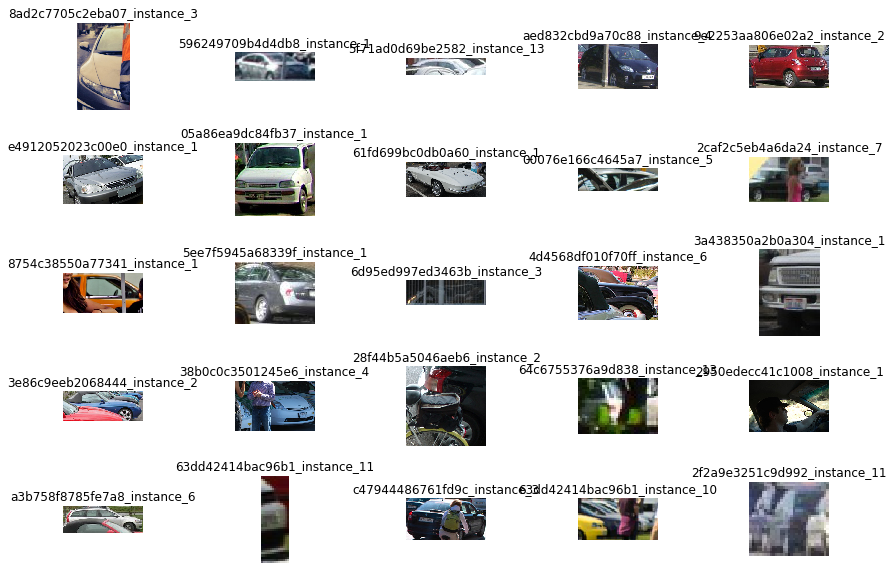

In [5]:
# Get list of .jpg files in car_bbox_out
input_path = glob.glob('car_bbox_out/*.jpg')
print('Found %i images...'%(len(input_path)))

# Visualize images with plot
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 5
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(input_path[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess(input_path[i])
    plt.axis(False)
    plt.imshow(img)
plt.tight_layout(True)
plt.show()

(51, 17)

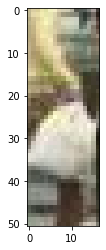

In [9]:
im = cv2.imread(input_path[56])
plt.imshow(im)
im.shape[:2]


## get detected license plates

(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None


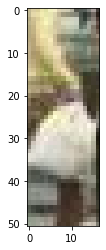

In [21]:
def detect_plate(img_path):
    '''
    Input: img_path (STR)
    This function calculates the Resizing-Factor mentioned in the paper
    Dmin = 288 and Dmax = 608 are chosen such that it produces optimal
        results between accuracy and running time
    '''
    Dmax = 608
    Dmin = 288
    bbox = preprocess(img_path)
    # get width:height image ratio     
    ratio = float(max(bbox.shape[:2]) / min(bbox.shape[:2]))
    size = int(ratio*Dmin)
    bound = min(size, Dmax)
    # Detect LP with wpod-net
    try:
        _ , LpImg, _, cor = detect_lp(wpod_net, bbox, bound, lp_threshold=0.5)
        return LpImg, cor
    except TypeError:
        print('No LP detected, return None')
        return None, None
        

# 34, 270 has detectable plate
# 56
demo = input_path[56]
LpImg, cor = detect_plate(demo)

if LpImg:
    print("Detect %i plate(s) in"%len(LpImg),splitext(basename(demo))[0])
    print("Coordinate of plate(s) in image: \n", cor)

    # Visualize our result
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.axis(False)
    plt.imshow(preprocess(demo))
    plt.subplot(1,2,2)
    plt.axis(False)
    plt.imshow(LpImg[0])
else:
    demo_img = cv2.imread(demo)
    plt.imshow(demo_img)

